# Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Kaggle/bank-direct-marketing-campaigns.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing

In [ ]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
df.shape

(41188, 20)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

In [ ]:
df.columns[df.dtypes == 'object']

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')

In [ ]:
df.rename(columns={'default': 'has_credit_card'}, inplace=True)
df.rename(columns={'poutcome': 'prev_outcome'}, inplace=True)

In [ ]:
df.columns[df.dtypes != 'object']

Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [ ]:
df.rename(columns={'emp.var.rate': 'emp_var_rate'}, inplace=True)
df.rename(columns={'cons.conf.idx': 'confidence_index'}, inplace=True)
df.rename(columns={'cons.price.idx': 'price_index'}, inplace=True)
df.rename(columns={'euribor3m': 'eur_3month'}, inplace=True)
df.rename(columns={'nr.employed': 'no_of_employees'}, inplace=True)

In [ ]:
df.head()

,age,job,marital,education,has_credit_card,housing,loan,contact,month,day_of_week,campaign,pdays,previous,prev_outcome,emp_var_rate,price_index,confidence_index,eur_3month,no_of_employees,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Unique values in categorical features

In [ ]:
for col in list(df.columns[df.dtypes == 'object']):
  print(df[col].unique())

['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
['married' 'single' 'divorced' 'unknown']
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
['no' 'unknown' 'yes']
['no' 'yes' 'unknown']
['no' 'yes' 'unknown']
['telephone' 'cellular']
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
['mon' 'tue' 'wed' 'thu' 'fri']
['nonexistent' 'failure' 'success']
['no' 'yes']


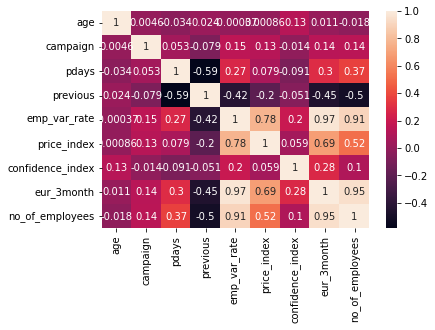

In [ ]:
sns.heatmap(df.corr(), annot=True)

Removing correlated features

In [ ]:
df.drop('eur_3month', inplace=True, axis=1)
df.drop('emp_var_rate', inplace=True, axis=1)

# Outlier Handling

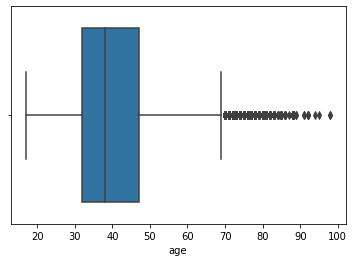

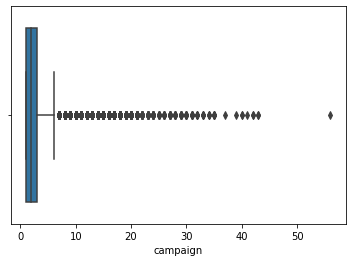

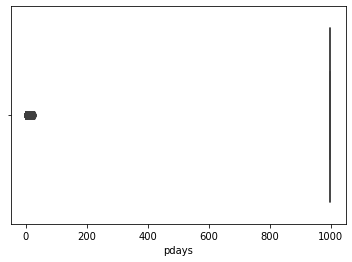

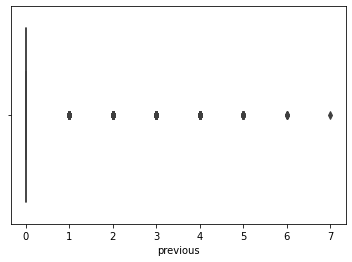

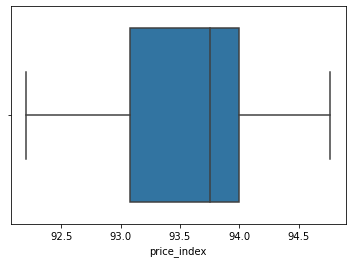

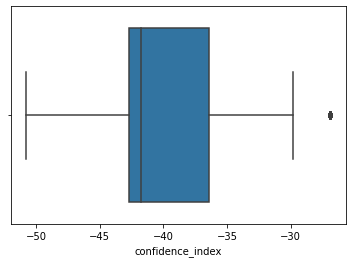

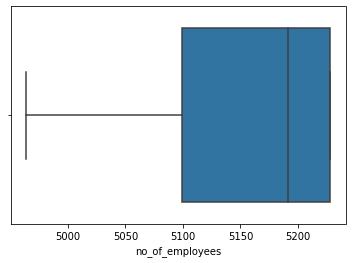

In [ ]:
for i, col in enumerate(list(df.columns[df.dtypes != 'object'])):
  plt.figure(i)
  ax = sns.boxplot(x=df[col])

In [ ]:
outliers = []
def detect_outliers_iqr(data):
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    for i in data: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers

Replace outlier values with median

In [ ]:
for col in ['age', 'campaign', 'pdays', 'confidence_index']:
  sample_outliers = detect_outliers_iqr(df[col])
  median = np.median(df[col])
  for i in sample_outliers:
      df[col] = np.where(df[col]==i, median, df[col])

In [ ]:
df.drop('pdays', axis=1, inplace=True)

Encoding categorical features

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
X = df.drop(['y'], axis=1).apply(le.fit_transform)

In [ ]:
X['y'] = df['y']
X.loc[X['y'] == 'no', 'y'] = 0
X.loc[X['y'] == 'yes', 'y'] = 1
y = np.array(X['y'], dtype=np.float)
X.drop('y', axis=1, inplace=True)

# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 40)

Standardizing dataset

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Modeling

In [ ]:
model = keras.Sequential(
    [
     keras.layers.Dense(100, activation='relu', input_shape=(16,)),
     keras.layers.Dense(50, activation='relu'),
     keras.layers.Dropout(0.2),
     keras.layers.Dense(50, activation='relu'),
     keras.layers.Dropout(0.2),
     keras.layers.Dense(1, activation='sigmoid'),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1700      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 9,351
Trainable params: 9,351
Non-trainable params: 0
______________________________________________________

In [ ]:
metrics = [
           keras.metrics.Precision(),
           keras.metrics.Recall()
          ]
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001), metrics=metrics, loss=keras.losses.BinaryCrossentropy())

In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=250, verbose=2, shuffle=True, validation_split=0.20)

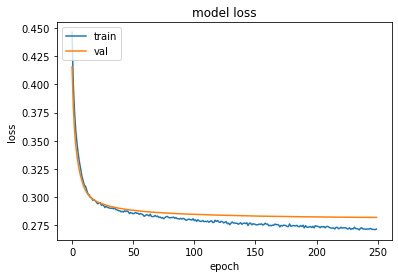

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

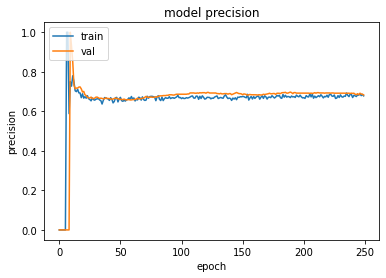

In [ ]:
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

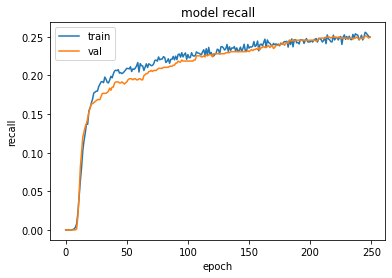

In [ ]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(scaler.transform(X_test))
y_pred = np.array(list(map(lambda x: 1 if x > 0.5 else 0, y_pred)))

0.8911143481427531

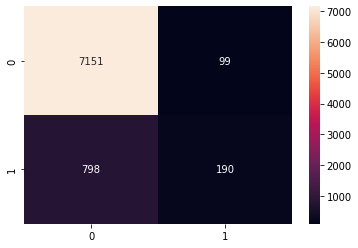

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, fmt='g', annot=True)
accuracy_score(y_test, y_pred)